In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

from scipy.stats import norm
from dateutil import relativedelta
from pykrx import stock

In [5]:
def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def gamma (option_type, S, K, r, T, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * (sigma ** 2)) * T ) / (sigma * np.sqrt(T))

    return stats.norm.pdf(d1) / (sigma * S * np.sqrt(T))

def new_next_exp(today):

    today = dt.datetime.strptime(today, '%Y-%m-%d')

    next_mon = today + relativedelta.relativedelta(months=1)
    nnext_mon = next_mon + relativedelta.relativedelta(months=1)

    if today.day < 15:
        result = next_mon
    else:
        result = nnext_mon
        
    return result.strftime("%Y%m")

def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    date = new_next_exp(date)
    base_date = dt.datetime.strptime(date, '%Y%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def tau_creator (today, date):
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    
    return (date - today).days/252

def tau_arr_creator (today, date):

    days = tau_creator(today, date) * 252
    
    return (np.flip(np.arange(0, days+1)) * 1/252).reshape(-1,1)

def delta_cal (s, k, r, q, vol, t):

    def d1_cal (s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))
        
    return norm.cdf(d1_cal(s, k, r, q, vol, t))

def atm_mapping (df, s0):
    '''Option MultiIndex df with spot price'''
    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    atm_k = k_arr[np.where((s0 - k_arr)>0)][-1]

    return atm_k

def otm_mapping (df, s0, mul):

    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    otm_k = k_arr[np.where((s0 * (1 + mul) - k_arr)>0)][-1]

    return otm_k



In [3]:
file_path = os.getcwd() + '/Data/'

kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']
kospi200_vol = pd.DataFrame(np.log(kospi200).diff().rolling(60).std() * np.sqrt(252)).dropna()
kospi200_vol.index = pd.to_datetime(kospi200_vol.index)
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)

In [4]:
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')


data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df


cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [18]:
'''거래 승수 (만 단위)'''
mul = 5

'''Time 관련'''

date    = '2007-08-01'
exdate  = new_next_exp(date)
ex_date = option_date_creator(1, date)
#t       = tau_creator(date, ex_date)
#t_arr   = tau_arr_creator(date, ex_date)

'''포지션 비율'''

long_num = 1
short_num = 2

'''투자 Horizon'''

i_horizon   = len(kospi200.loc[date:ex_date])
tau_arr     = (np.flip(np.arange(0, i_horizon)) * 1/252).reshape(-1,1)
tau         = tau_arr[0].item()

'''Input Params'''

s0      = kospi200.loc[date]
s0_arr  = kospi200.loc[date:ex_date].to_numpy().reshape(-1,1)
s0_vol  = kospi200_vol.loc[date].values[0]
s0_vol_arr  = kospi200_vol.loc[date:ex_date].to_numpy().reshape(-1,1)
r       = rf.loc[date].values[0]

test        = pd.DataFrame(df.loc[date, ('C', exdate, slice(None), slice(None))]).T
atm_k       = atm_mapping(test, s0) - 30
otm_k       = otm_mapping(test, s0, 0.15) 
op_pr_atm   = df.loc[date, ('C', exdate, str(atm_k), ['종가'])].values[0]
op_pr_otm   = df.loc[date, ('C', exdate, str(otm_k), ['종가'])].values[0]
iv          = df.loc[date, ('C', exdate, str(otm_k), ['내재변동성'])].values[0]

'''Cost들'''

init_cost = op_pr_otm * short_num + op_pr_atm * long_num

print(s0_vol)
pd.DataFrame(df.loc[date, ('C', exdate, [str(atm_k), str(otm_k)], slice(None))])

0.21090308034562769


2007-08-01
cpflag tick   strike feature           
C      200709 202.5  종가            32.3
                     기준가           42.5
                     거래량              0
                     내재변동성        0.297
                     미결제약정           36
              267.5  종가            0.75
                     기준가           1.71
                     거래량           2808
                     내재변동성        0.254
                     미결제약정         8351

atm 근처에서 > Long Gamma > 옵션 매수이므로 현물 숏? <br>
otm 경우에는 > Short Gamma > 옵션 매도이므로 현물 보유?

In [19]:
init_cost * mul

169.0

In [22]:
s0

234.36

234.36


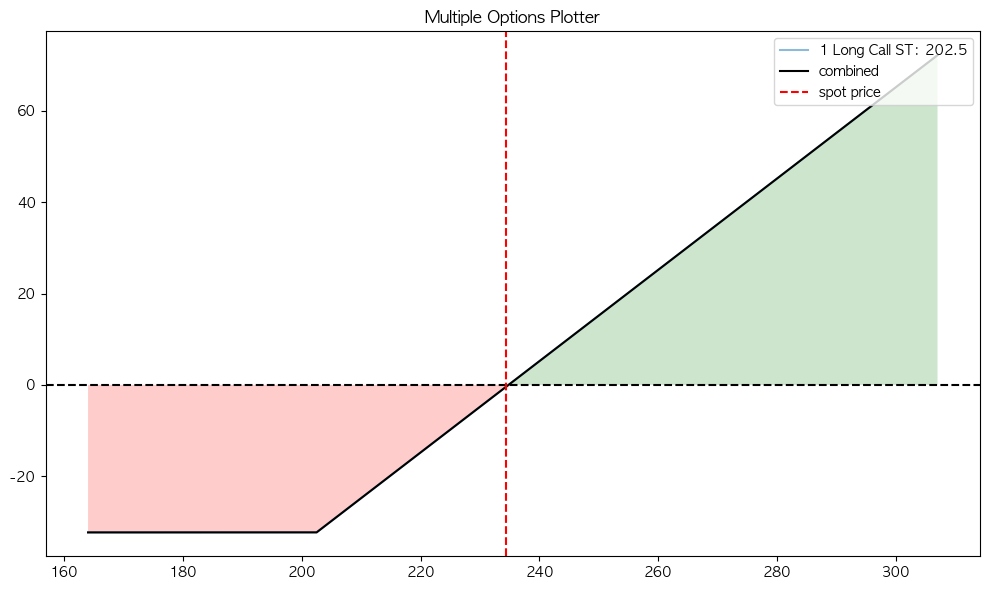

In [27]:
import opstrat as op

#op.single_plotter(spot=s0, strike=atm_k, op_type='c', tr_type='s', op_pr=op_pr_atm)

op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'b', 'op_pr':op_pr_atm}
op_2 = {'op_type':'c', 'strike':otm_k, 'tr_type':'s', 'op_pr':op_pr_otm}

op_list = [op_1]
print(s0)
op.multi_plotter(spot=s0, spot_range=30, op_list=op_list)

In [25]:
def path_changes (path_1):
    '''calculate path's changes'''

    return np.vstack([path_1[0], path_1[1:] - path_1[:-1]])

def create_hedging_df (s0_arr, atm_k, otm_k, r, q, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200):

    st_delta_path = \
    np.round(delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num * -1 + \
             delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * 1, 3)

    st_delta_path = pd.DataFrame(st_delta_path, columns=['Delta'])
    st_delta_path.index = kospi200.loc[date:ex_date].index

    st_delta_path['Delta_ch'] = path_changes(st_delta_path.to_numpy())

    st_delta_path['spot_price(Close)'] = s0_arr


    st_delta_path['Cost_ch'] = st_delta_path[['Delta_ch']] * s0_arr

    st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

    st_delta_path['Hist_vol'] = s0_vol_arr

    return st_delta_path

create_hedging_df(s0_arr, atm_k, otm_k, r, 0, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200)

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-08-01,-0.894,-0.894,234.36,-209.51784,-209.51784,0.210903
2007-08-02,-0.905,-0.011,233.84,-2.57224,-212.09008,0.210549
2007-08-03,-0.884,0.021,236.91,4.97511,-207.11497,0.211616
2007-08-06,-0.919,-0.035,233.92,-8.18720,-215.30217,0.213753
2007-08-07,-0.922,-0.003,234.50,-0.70350,-216.00567,0.213734
2007-08-08,-0.868,0.054,240.07,12.96378,-203.04189,0.218138
2007-08-09,-0.863,0.005,241.00,1.20500,-201.83689,0.218132
2007-08-10,-0.958,-0.095,230.68,-21.91460,-223.75149,0.236640
2007-08-13,-0.952,0.006,233.88,1.40328,-222.34821,0.237667
